In [ ]:
#######Extract coordinates from the txt file to make poses_3D########

import numpy as np
import decimal

# Set the decimal precision to 16 places
decimal.getcontext().prec = 16

file_path = "S1D3.txt"
data = []

with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            coordinates = line
            data.append(coordinates)

frame_list = []
count = 0
for fdata in data:
    count=count+1
    frame_joint_coordinates = {}
    fdata_list = eval(fdata)
    for item in fdata_list:
        joint_data = item.split(': ')
        joint = joint_data[0]
        coordinates = joint_data[1].strip('[]').split(', ')
        x, y, z = [float(c) for c in coordinates]
        frame_joint_coordinates[joint] = np.array([x, y, z])
    frame_list.append(frame_joint_coordinates)

import numpy as np

# Assuming frame_list is your list of dictionaries containing joint coordinates

num_frames = len(frame_list)
num_joints = len(frame_list[0])  # Assuming all frames have the same number of joints

# Initialize poses_3d array
poses_3d = np.zeros((num_frames, num_joints, 3))

# Create a dictionary to map joint names to indices
joint_indices = {
    'HipCenter': 0,
    'Spine': 1,
    'Spine1': 2,
    'Spine2': 3,
    'Spine3': 4,
    'Spine4': 5,
    'ShoulderCenter': 6,
    'Head': 7,
    'ShoulderLeft': 8,
    'ElbowLeft': 9,
    'WristLeft': 10,
    'HandLeft': 11,
    'ShoulderRight': 12,
    'ElbowRight': 13,
    'WristRight': 14,
    'HandRight': 15,
    'HipLeft': 16,
    'KneeLeft': 17,
    'AnkleLeft': 18,
    'FootLeft': 19,
    'HipRight': 20,
    'KneeRight': 21,
    'AnkleRight': 22,
    'FootRight': 23
    }

for frame_index, frame in enumerate(frame_list):
    for joint_name, joint_coordinates in frame.items():
        joint_index = joint_indices[joint_name]
        x, y, z = joint_coordinates
        poses_3d[frame_index, joint_index] = [x*100, y*100, z*100]

In [ ]:
####### Average movement for each joint per frame ###########

def calculate_average_movement(poses_3d):
    # Calculate differences between each pair of successive frames
    differences = np.diff(poses_3d, axis=0)

    # Calculate the magnitude of movement for each joint in each frame
    magnitudes = np.linalg.norm(differences, axis=2)

    # Calculate the average movement for each joint
    average_movements = np.mean(magnitudes, axis=0)

    return average_movements

# First, create an inverse mapping from indices to joint names
index_to_joint = {index: joint for joint, index in joint_indices.items()}

# Calculate average movement for each joint using your existing function
average_joint_movements = calculate_average_movement(poses_3d)

# Now, output the average movement with the joint name
print("AVERAGE MOVEMENT PER FRAME: \n")
for joint_index, movement in enumerate(average_joint_movements):
    joint_name = index_to_joint[joint_index]
    print(f"{joint_name}: {movement}")



AVERAGE MOVEMENT PER FRAME: 

HipCenter: 0.6172518192093424
Spine: 0.6338116355047648
Spine1: 0.6554841899013214
Spine2: 0.6899528984049077
Spine3: 0.7345757739067081
Spine4: 0.787739058231885
ShoulderCenter: 0.8490520952994474
Head: 1.0106554067005682
ShoulderLeft: 0.9007745358747727
ElbowLeft: 1.2413623010602939
WristLeft: 1.800549686703081
HandLeft: 2.0952006074687417
ShoulderRight: 0.815935268482961
ElbowRight: 1.555699480033016
WristRight: 2.212031058843836
HandRight: 2.905125648194706
HipLeft: 0.6603911895333541
KneeLeft: 1.0465444285258214
AnkleLeft: 1.3545009787127082
FootLeft: 1.829391123702514
HipRight: 0.6019778143943967
KneeRight: 0.708638865192242
AnkleRight: 1.202915065026058
FootRight: 1.5260756011843684


In [ ]:
import numpy as np

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def smooth_poses_3d(poses_3d, window_size):
    num_frames, num_joints, _ = poses_3d.shape
    # Initialize the smoothed poses_3d array with NaNs to handle the reduced size after moving average
    smoothed_poses_3d = np.full((num_frames, num_joints, 3), np.nan)

    # Apply moving average to each joint coordinate
    for joint_index in range(num_joints):
        for coordinate_index in range(3):  # X, Y, Z coordinates
            smoothed_data = moving_average(poses_3d[:, joint_index, coordinate_index], window_size)
            # Fill the smoothed data back into the array, centered
            start_index = window_size // 2
            end_index = start_index + len(smoothed_data)
            smoothed_poses_3d[start_index:end_index, joint_index, coordinate_index] = smoothed_data

    return smoothed_poses_3d

# Define the window size for the moving average
window_size = 5

# Apply the smoothing function to the entire poses_3d array
poses_3d_smoothed = smooth_poses_3d(poses_3d, window_size)

# After applying moving average and getting poses_3d_smoothed
for joint_index in range(num_joints):
    for coordinate_index in range(3):  # X, Y, Z coordinates
        # Forward fill
        nan_indices = np.where(np.isnan(poses_3d_smoothed[:, joint_index, coordinate_index]))[0]
        if nan_indices.size > 0 and nan_indices[0] == 0:  # If NaNs are at the start
            next_valid_index = np.where(~np.isnan(poses_3d_smoothed[:, joint_index, coordinate_index]))[0][0]
            poses_3d_smoothed[:next_valid_index, joint_index, coordinate_index] = poses_3d_smoothed[next_valid_index, joint_index, coordinate_index]

        # Backward fill
        nan_indices = np.where(np.isnan(poses_3d_smoothed[:, joint_index, coordinate_index]))[0]
        if nan_indices.size > 0 and nan_indices[-1] == len(poses_3d_smoothed[:, joint_index, coordinate_index]) - 1:  # If NaNs are at the end
            last_valid_index = np.where(~np.isnan(poses_3d_smoothed[:, joint_index, coordinate_index]))[0][-1]
            poses_3d_smoothed[last_valid_index + 1:, joint_index, coordinate_index] = poses_3d_smoothed[last_valid_index, joint_index, coordinate_index]

# Now poses_3d_smoothed contains the smoothed data for all joints without NaNs

# poses_3d = poses_3d_smoothed


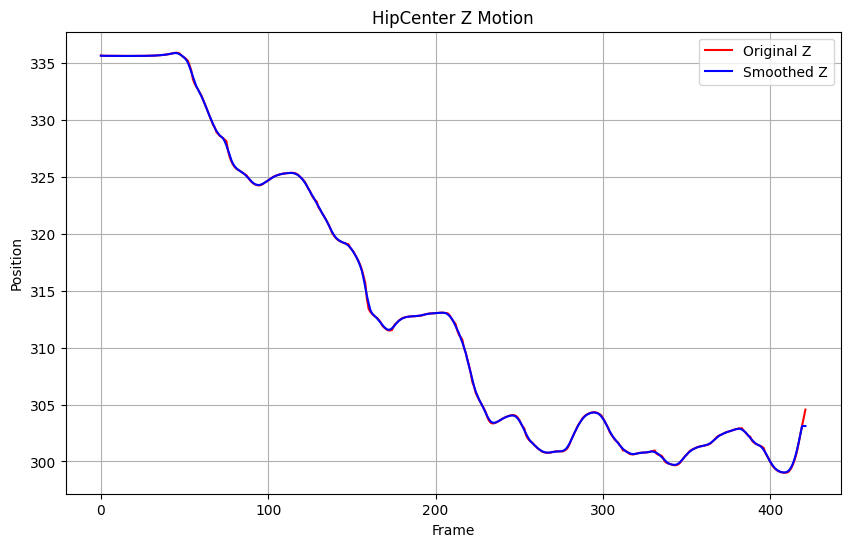

In [ ]:
# Function to plot the motion for a specific joint and axis
def plot_joint_motion(poses_3d, poses_3d_smoothed, joint_index, axis_index, joint_name, axis_name):
    plt.figure(figsize=(10, 6))
    plt.plot(poses_3d[:, joint_index, axis_index], label=f'Original {axis_name}', color='red')
    plt.plot(poses_3d_smoothed[:, joint_index, axis_index], label=f'Smoothed {axis_name}', color='blue')
    plt.title(f'{joint_name} {axis_name} Motion')
    plt.xlabel('Frame')
    plt.ylabel('Position')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
joint_indices = {'HipCenter': 0, 'HandLeft': 11, 'HandRight': 15}  # Adjust according to your data structure
axis_indices = {'X': 0, 'Y': 1, 'Z': 2}

# Assuming 'poses_3d' and 'poses_3d_smoothed' are already defined and populated
plot_joint_motion(poses_3d, poses_3d_smoothed, joint_indices['HipCenter'], axis_indices['Z'], 'HipCenter', 'Z')


In [ ]:
import numpy as np

def calculate_displacements(poses_3d, window_size):
    # Initialize a list to hold displacement magnitudes for each window
    window_displacements = []

    # Initialize an array to hold the sum of displacement magnitudes for each joint
    displacement_magnitude_sums = np.zeros(poses_3d.shape[1])

    # Calculate the number of windows
    num_windows = poses_3d.shape[0] - window_size + 1

    for start_frame in range(num_windows):
        # Calculate the end frame for this window
        end_frame = start_frame + window_size - 1

        # Calculate displacement for this window
        displacement = poses_3d[end_frame] - poses_3d[start_frame]

        # Calculate the magnitude of displacement for each joint in this window
        displacement_magnitudes = np.linalg.norm(displacement, axis=1)

        # Add the displacement magnitudes to the sum (for averaging later)
        displacement_magnitude_sums += displacement_magnitudes

        # Append the displacement magnitudes of this window to the list
        window_displacements.append(displacement_magnitudes)

    # Calculate the average displacement magnitude for each joint
    average_displacement_magnitudes = displacement_magnitude_sums / num_windows

    return average_displacement_magnitudes, window_displacements

# Specify the window size
window_size = 30

# Calculate average displacement magnitude for each joint and store each window's displacement magnitudes
average_joint_displacement_magnitudes, window_displacement_magnitudes = calculate_displacements(poses_3d, window_size)

# Output the average displacement magnitude for each joint
print(f"AVERAGE DISPLACEMENT MAGNITUDE PER JOINT OVER ALL WINDOWS:")
for joint_index, magnitude in enumerate(average_joint_displacement_magnitudes):
    joint_name = index_to_joint[joint_index]  # Use the inverse mapping to get the joint name
    print(f"{joint_name}: {magnitude}")


AVERAGE DISPLACEMENT MAGNITUDE PER JOINT OVER ALL WINDOWS:
HipCenter: 10.371052826288597
Spine: 10.592329400327273
Spine1: 11.000746568588532
Spine2: 11.741177108106056
Spine3: 12.790061148809425
Spine4: 14.089908659321948
ShoulderCenter: 15.53880298547248
Head: 19.71516408717837
ShoulderLeft: 14.019474131029526
ElbowLeft: 17.80367401948434
WristLeft: 25.558000213901018
HandLeft: 29.661540833822365
ShoulderRight: 14.098039634988588
ElbowRight: 20.668793126386813
WristRight: 29.08914139812128
HandRight: 34.82313256996761
HipLeft: 11.002300483029796
KneeLeft: 10.407971099808053
AnkleLeft: 13.925701813735348
FootLeft: 15.213751121472862
HipRight: 9.98554418245586
KneeRight: 8.81022815970352
AnkleRight: 14.612427895768281
FootRight: 15.689289995683342


In [ ]:
import numpy as np

def calculate_weighted_averages(average_displacement_magnitudes, window_displacements, weights, joint_indices):
    # Convert weights to an array in the same order as displacement magnitudes
    weights_array = np.array([weights[joint] for joint in joint_indices])

    # Calculate overall weighted average
    overall_weighted_average = np.sum(average_displacement_magnitudes * weights_array) / np.sum(weights_array)

    # Calculate weighted averages for each window
    window_weighted_averages = [np.sum(window * weights_array) / np.sum(weights_array) for window in window_displacements]

    return overall_weighted_average, window_weighted_averages

# Define weights for each joint
weights = {
    "HipCenter": 4, "HipLeft": 3, "KneeLeft": 1, "AnkleLeft": 0, "FootLeft": 0,
    "HipRight": 3, "KneeRight": 1, "AnkleRight": 0, "FootRight": 0,
    "Spine": 3, "Spine1": 3, "Spine2": 3, "Spine3": 3, "Spine4": 3,
    "ShoulderRight": 2, "ElbowRight": 2, "WristRight": 2, "HandRight": 1,
    "ShoulderLeft": 2, "ElbowLeft": 2, "WristLeft": 2, "HandLeft": 1,
    "ShoulderCenter": 3, "Head": 2
}

# Define joint indices to match the order of weights and the displacement magnitudes
joint_indices = [
    "HipCenter", "HipLeft", "KneeLeft", "AnkleLeft", "FootLeft",
    "HipRight", "KneeRight", "AnkleRight", "FootRight",
    "Spine", "Spine1", "Spine2", "Spine3", "Spine4",
    "ShoulderRight", "ElbowRight", "WristRight", "HandRight",
    "ShoulderLeft", "ElbowLeft", "WristLeft", "HandLeft",
    "ShoulderCenter", "Head"
]

# Usage example (you need to define 'average_displacement_magnitudes' and 'window_displacements' before this)
overall_weighted_average, window_weighted_averages = calculate_weighted_averages(
    average_joint_displacement_magnitudes, window_displacement_magnitudes, weights, joint_indices)


In [ ]:
def direct_identify_local_minima_with_threshold(window_weighted_averages, distance=1, X_threshold=3):
    key_windows = []
    for i in range(distance, len(window_weighted_averages) - distance):
        # Extract a slice around the current point to check for a local minimum
        window_slice = window_weighted_averages[i-distance:i+distance+1]
        if window_weighted_averages[i] == min(window_slice):
            # Initially assume this is a valid key frame
            is_key_window = True

            # Check if the trend for the next X_threshold windows is increasing
            for j in range(1, X_threshold + 1):
                # Ensure we don't go beyond the array bounds
                if i + j >= len(window_weighted_averages):
                    break
                # If any subsequent window does not follow the increasing trend, invalidate this key frame
                if window_weighted_averages[i + j - 1] > window_weighted_averages[i + j]:
                    is_key_window = False
                    break

            # If the key frame is still valid after checking the trend, add it to the list
            if is_key_window:
                key_windows.append(i)

    return key_windows

# Using the modified direct search method with the increasing trend condition
key_frames_minima_direct_with_threshold = direct_identify_local_minima_with_threshold(window_weighted_averages, distance=5, X_threshold=5)
print("Key Frames Windows (Direct Local Minima with Increasing Trend):", key_frames_minima_direct_with_threshold)



Key Frames Windows (Direct Local Minima with Increasing Trend): [108, 184, 211, 235, 277, 305, 356]


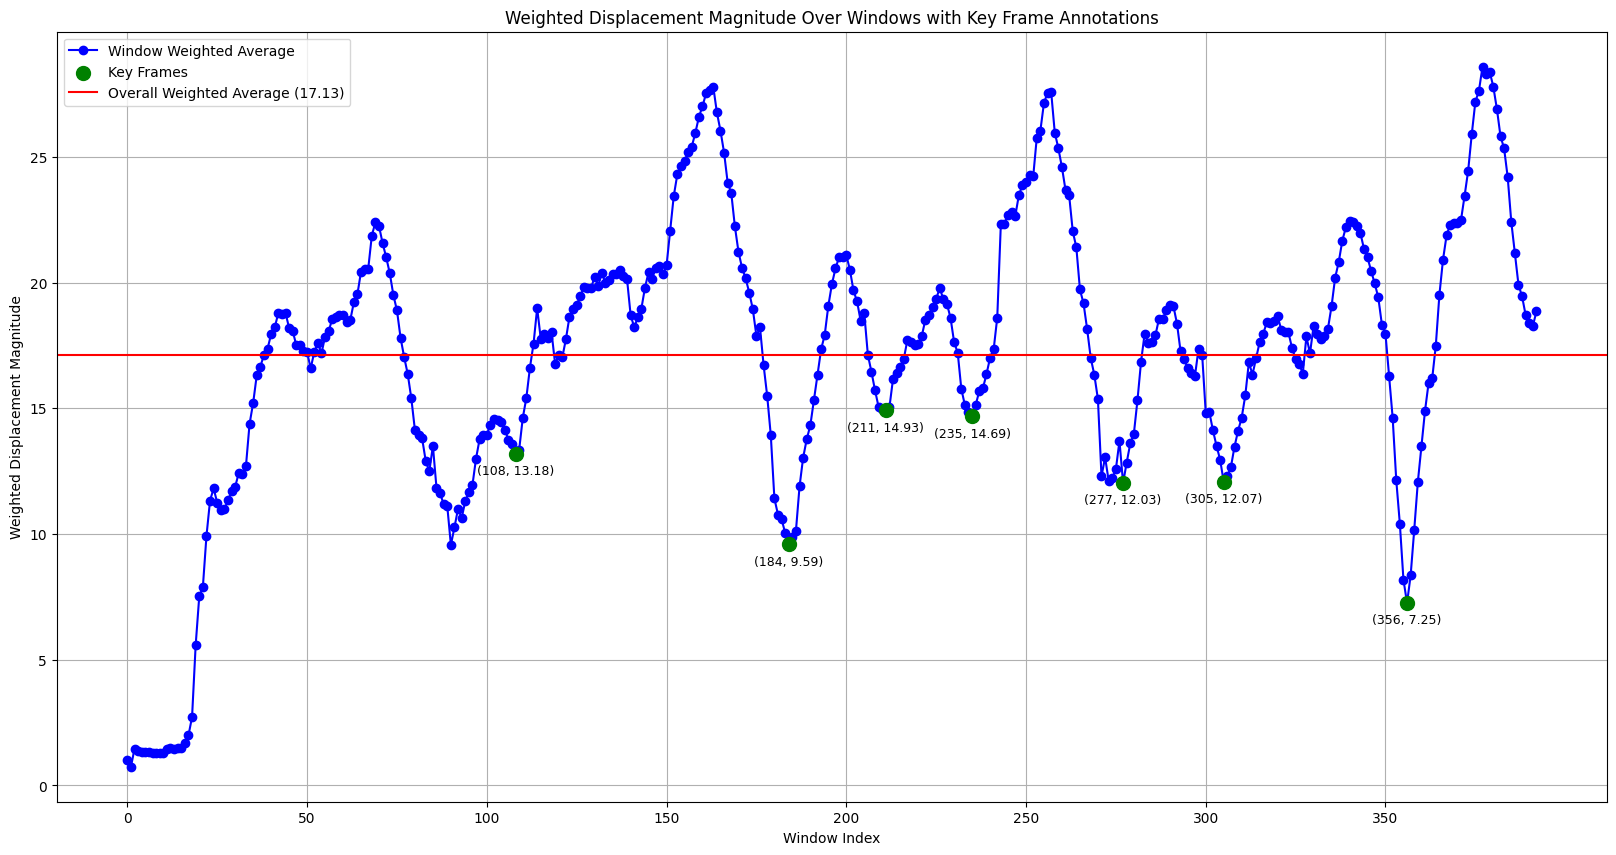

In [ ]:
import matplotlib.pyplot as plt

def plot_weighted_displacements_with_keypoints_and_annotations(window_weighted_averages, overall_weighted_average, key_frames, title="Weighted Displacement over Windows"):
    # Prepare the x-axis data: window indices
    x = range(len(window_weighted_averages))

    # Plotting the weighted average displacement for each window
    plt.figure(figsize=(20, 10))  # Adjust figure size as needed
    plt.plot(x, window_weighted_averages, marker='o', linestyle='-', color='b', label='Window Weighted Average')

    # Highlighting key frames
    key_frame_values = [window_weighted_averages[k] for k in key_frames]
    plt.scatter(key_frames, key_frame_values, color='g', s=100, label='Key Frames', zorder=5)  # Ensure markers are plotted above the line

    # Annotate key frames with their coordinates
    for i, key_frame in enumerate(key_frames):
        plt.annotate(f"({key_frame}, {key_frame_values[i]:.2f})", # Text to display
                     (key_frame, key_frame_values[i]), # Point to annotate
                     textcoords="offset points", # How to position the text
                     xytext=(0,-15), # Distance from text to points (x,y)
                     ha='center', # Horizontal alignment
                     fontsize=9) # Font size

    # Drawing the overall weighted average as a horizontal line
    plt.axhline(y=overall_weighted_average, color='r', linestyle='-', label=f'Overall Weighted Average ({overall_weighted_average:.2f})')

    # Title and labels
    plt.title(title)
    plt.xlabel("Window Index")
    plt.ylabel("Weighted Displacement Magnitude")

    # Setting x-axis ticks every 50 units
    plt.xticks(range(0, len(window_weighted_averages) + 1, 50))

    # Adding grid and legend
    plt.grid(True)
    plt.legend()

    # Show plot
    plt.show()

plot_weighted_displacements_with_keypoints_and_annotations(window_weighted_averages, overall_weighted_average, key_frames_minima_direct_with_threshold, title="Weighted Displacement Magnitude Over Windows with Key Frame Annotations")


Key Window Indices (Advanced Checks): [10, 51, 90, 108, 119, 141, 184, 211, 235, 277, 305, 327, 356]


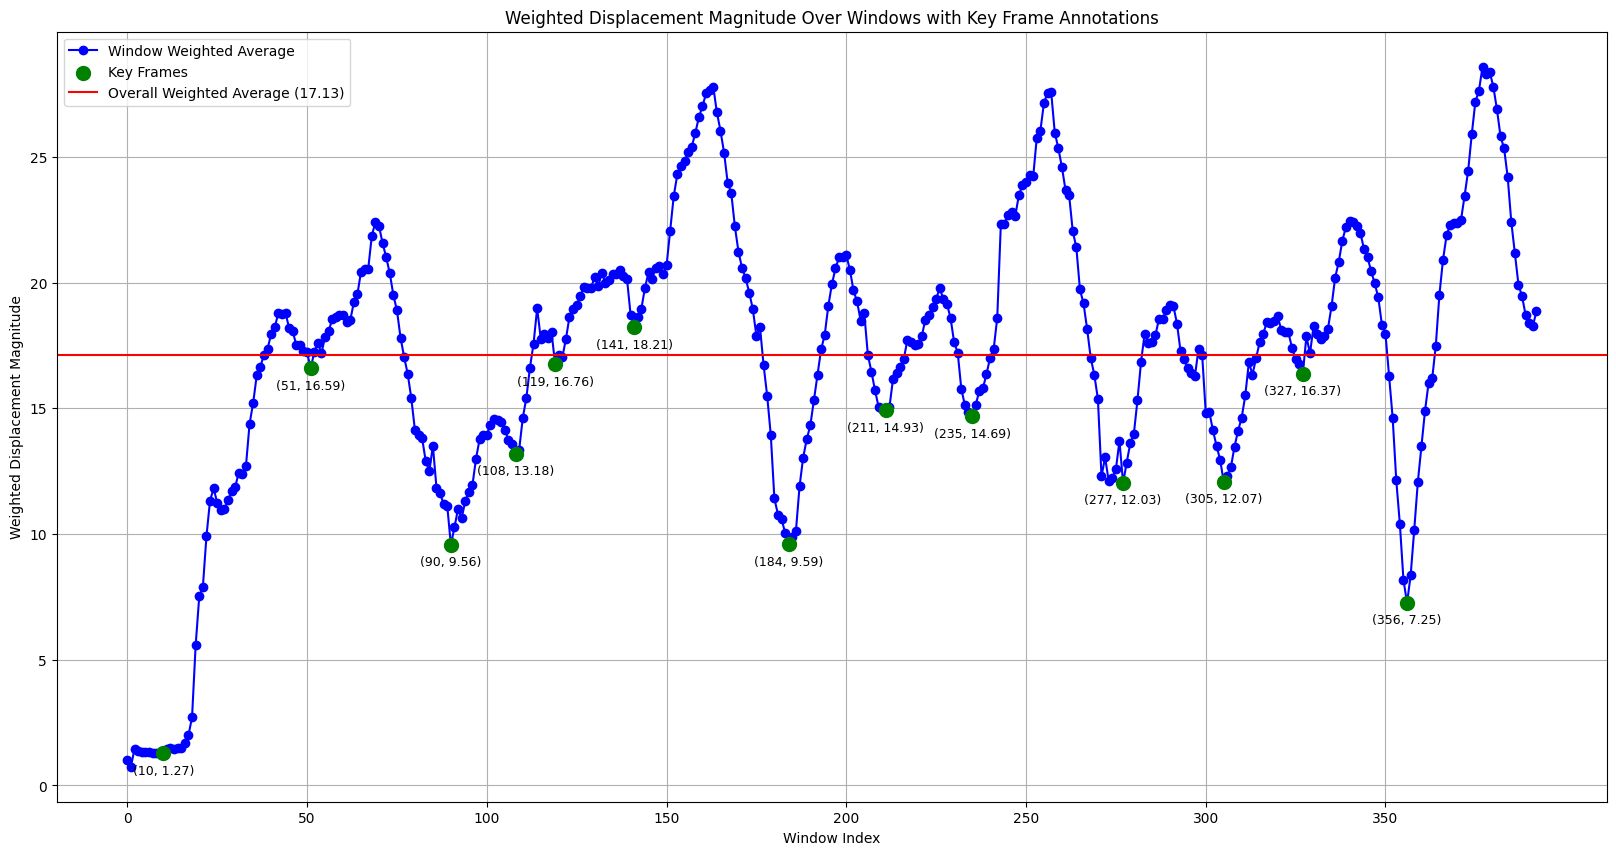

In [ ]:
def check_increasing_trend(sequence, allowance_value):
    decreases_allowed = allowance_value
    for i in range(1, len(sequence)):
        if sequence[i] < sequence[i-1]:
            decreases_allowed -= 1
            if decreases_allowed < 0:
                return False
    return True

def check_plateau(sequence, threshold_range):
    return max(sequence) - min(sequence) <= threshold_range

def direct_identify_local_minima_with_advanced_checks(window_weighted_averages, distance, X_threshold, allowance_value, threshold_range=0.1):
    key_windows = []
    for i in range(distance, len(window_weighted_averages) - distance):
        window_slice = window_weighted_averages[i-distance:i+distance+1]
        if window_weighted_averages[i] == min(window_slice):
            left_sequence = window_weighted_averages[max(0, i-X_threshold):i]
            right_sequence = window_weighted_averages[i+1:min(len(window_weighted_averages), i+1+X_threshold)]

            # Perform checks
            check1_left = check_increasing_trend(left_sequence[::-1], allowance_value)
            check1_right = check_increasing_trend(right_sequence, allowance_value)
            check2 = check_plateau(window_slice, threshold_range)

            if (check1_left and check1_right) or check2:
                key_windows.append(i)

    return key_windows

# Using the updated method with advanced checks
key_windows_advanced = direct_identify_local_minima_with_advanced_checks(window_weighted_averages, distance=5, X_threshold=3, allowance_value=2, threshold_range=0.1)
print("Key Window Indices (Advanced Checks):", key_windows_advanced)

plot_weighted_displacements_with_keypoints_and_annotations(window_weighted_averages, overall_weighted_average, key_windows_advanced, title="Weighted Displacement Magnitude Over Windows with Key Frame Annotations")
